# Usha Manoharan
## Capstone Project  - Commuter friendly Neighborhoods of San Francisco, CA, USA

This notebook will be used for the **"Battle of Neighborhoods"** capstone project of the IBM Applied DataScience Professional Certificate course. The purpose of this project is to identify the neighborhoods in San Francisco, USA, that are best suited to commute in local buses and trains.

I will start by downloading the zipcode data at [mellisa lookups](https://www.melissa.com/v2/lookups/cityzip/city/?name=san+francisco) to get a list of zip codes of San Francisco. Next I will use the pgeocode library to obtain the latitude and longitude for each zipcode in San Francisco. Then, I will use the Foursquare API to explore the neighborhoods by searching for bus and train stations and group them into clusters based on the venue categories that are related to public transportation. I will use the k-means clustering algorithm to cluster the neighborhoods. Finally, I will use the Folium library to visualize the neighborhood clusters in San Francisco that have the most number of bus and train stations to commute.

## Table Of Contents
* [San Francisco Neighborhood](#get-sfdata)
* [Explore Transit options of San Francisco](#explore-sfdata)
* [Analyze Transit options of San Francisco](#analyze-sfdata)
* [Commuter Clusters of San Francisco](#cluster-sfdata)
* [Discussion](#discuss-sfdata)


## San Francisco neighborhood  <a class="anchor" id="get-sfdata"></a>

In [620]:
# load all the libraried needed for the analysis.
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#https://pypi.org/project/pgeocode/ -- to convert zipcode to lat and long
import pgeocode

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib.pyplot as plt

print('All Libraries imported.')

All Libraries imported.


#### Get all zipcodes of San Francisco and show them in a map

In [621]:
#https://www.melissa.com/v2/lookups/cityzip/city/?name=san+francisco
df = pd.read_excel('https://github.com/umano-git/ibm-ads-capstone/blob/master/sfo-zipcodes.xlsx?raw=true')

# get latitue and longitude information for each zipcode
nomi = pgeocode.Nominatim('us')
# extract zipcode as a list, so it can be used in the nominatim call
ziplist=[]
for ind in df.index: 
    ziplist.append(str(df['ZIP'][ind]))

res = nomi.query_postal_code(ziplist)

cols = ['postal_code', 'latitude', 'longitude']
sfo = res.loc[:, cols]
sfo.rename(columns={"postal_code": "zipcode"}, inplace=True)
#sfo

In [622]:
# Let's pick the latitude and longitude of 94114 zip to center and map the zipcode neighborhoods.
latitude=37.7587
longitude=-122.4330


# create map of San Francisco using latitude and longitude values
map_sf = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='My location',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_sf)

# add markers to map
for lat, lng, zipcode in zip(sfo['latitude'], sfo['longitude'],sfo['zipcode']):
    label = '{}'.format(zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sf)  
    
map_sf

[screenshot of the map showing the zipcodes of San Francisco](https://github.com/umano-git/ibm-ads-capstone/blob/master/SFO-zipcode-map.png)

## Explore Transit options of San Francisco <a class="anchor" id="explore-sfdata"></a>

For this project I will use the Foursquare API to search venues that are categorized as "train" or "bus" stations in each of the zipcodes.  

In [672]:
# removed the foursquare API credentials for privacy concerns

VERSION = '20200725'
LIMIT = 30
radius = 500
    
def get_venue_df(search_query,v_lat,v_lng):    
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, v_lat, v_lng, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    
    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    
    # tranform venues into a dataframe
    venuedf = json_normalize(venues)
    return venuedf


### Search for the "train" and "bus" stations in each zipcode

In [673]:
sfo_venues = pd.DataFrame()

for name, lat, lng in zip(sfo['zipcode'], sfo['latitude'], sfo['longitude']):
    bdf = get_venue_df(search_query='bus',v_lat=lat,v_lng=lng)
    tdf = get_venue_df(search_query='train',v_lat=lat,v_lng=lng)
    venuedf = bdf.append(tdf,sort=False)
    venuedf.reset_index(drop=True, inplace=True)
    
    #skip the loop if there are empty results
    if(venuedf.size == 0):
        continue
    
    # keep only columns that include venue name, catogory, latitude, longitude
    filtered_columns = ['name', 'categories', 'location.address', 'location.lat', 'location.lng']
    #filtered_columns
    vdf_filtered = venuedf.loc[:, filtered_columns]

    #print(vdf_filtered.head(5))
    # filter the category for each row
    vdf_filtered['categories'] = vdf_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    vdf_filtered.columns = [column.split('.')[-1] for column in vdf_filtered.columns]
    # rename col names to indicate they are of the venue
    vdf_filtered.rename(columns={"name": "Venue Name","categories": "Venue Category","address": "Venue Address","lat": "Venue Latitude","lng": "Venue Longitude"}, inplace=True)
    #drop any row with NA in categories
    vdf_filtered.dropna(subset=['Venue Category'],inplace=True)
    
    #print(vdf_filtered.head(5))
        
    #insert the zipcode and its lat and lng
    vdf_filtered.insert(0,"Zipcode",name)
    vdf_filtered.insert(1,"Zipcode Latitude",lat)
    vdf_filtered.insert(2,"Zipcode Longitude",lng)    
    
    #append into sfo venues
    sfo_venues=sfo_venues.append(vdf_filtered)
    
sfo_venues.head(5)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,Zipcode,Zipcode Latitude,Zipcode Longitude,Venue Name,Venue Category,Venue Address,Venue Latitude,Venue Longitude
0,94163,37.7749,-122.4194,MUNI Bus Stop - Van Ness & Market,Bus Station,Van Ness Ave.,37.775657,-122.419270
1,94163,37.7749,-122.4194,Muni Bus 5474,Bus Line,NaN,37.774795,-122.420017
2,94163,37.7749,-122.4194,MUNI bus 8143,Bus Line,NaN,37.774355,-122.420631
3,94163,37.7749,-122.4194,MUNI bus #8198,Bus Line,NaN,37.776567,-122.419050
4,94163,37.7749,-122.4194,MUNI Bus Stop - Mission & 11th,Bus Line,Mission St,37.774149,-122.417307


In [674]:
# check the shape of sfo_venues
print(sfo_venues.shape)
sfo_venues

(1367, 8)


,Zipcode,Zipcode Latitude,Zipcode Longitude,Venue Name,Venue Category,Venue Address,Venue Latitude,Venue Longitude
0,94163,37.7749,-122.4194,MUNI Bus Stop - Van Ness & Market,Bus Station,Van Ness Ave.,37.775657,-122.419270
1,94163,37.7749,-122.4194,Muni Bus 5474,Bus Line,NaN,37.774795,-122.420017
2,94163,37.7749,-122.4194,MUNI bus 8143,Bus Line,NaN,37.774355,-122.420631
3,94163,37.7749,-122.4194,MUNI bus #8198,Bus Line,NaN,37.776567,-122.419050
4,94163,37.7749,-122.4194,MUNI Bus Stop - Mission & 11th,Bus Line,Mission St,37.774149,-122.417307
...,...,...,...,...,...,...,...,...
39,94137,37.7749,-122.4194,JG Martial Arts Training,Martial Arts Dojo,NaN,37.772532,-122.419827
40,94137,37.7749,-122.4194,Epic Hybrid Training,Gym / Fitness Center,1632 Market St,37.773736,-122.421144
0,94083,37.6547,-122.4077,South San Francisco Caltrain Station,Train Station,590 Dubuque Ave,37.657019,-122.404947
1,94083,37.6547,-122.4077,United Airlines Training Center,Conference Room,601 Gateway Ave,37.656387,-122.405411


In [675]:
sfo_venues.groupby('Zipcode').count()

,Zipcode Latitude,Zipcode Longitude,Venue Name,Venue Category,Venue Address,Venue Latitude,Venue Longitude
Zipcode,,,,,,,
94083,3,3,3,3,3,3,3
94102,39,39,39,39,25,39,39
94103,41,41,41,41,17,41,41
94104,47,47,47,47,40,47,47
94105,32,32,32,32,16,32,32
94107,19,19,19,19,13,19,19
94108,36,36,36,36,24,36,36
94109,33,33,33,33,25,33,33
94110,17,17,17,17,4,17,17


In [676]:
print('There are {} uniques categories.'.format(len(sfo_venues['Venue Category'].unique())))

There are 59 uniques categories.


## Analyze Transit options of San Francisco <a class="anchor" id="analyze-sfdata"></a>

In [677]:
# one hot encoding
sfo_onehot = pd.get_dummies(sfo_venues[['Venue Category']], prefix="", prefix_sep="")

# add zipcode column back to dataframe
sfo_onehot['Zipcode'] = sfo_venues['Zipcode'] 

# move neighborhood column to the first column
fixed_columns = [sfo_onehot.columns[-1]] + list(sfo_onehot.columns[:-1])
sfo_onehot = sfo_onehot[fixed_columns]

sfo_onehot.head()

,Zipcode,Art Gallery,Automotive Shop,Bar,Beer Garden,Building,Bus Line,Bus Station,Bus Stop,Business Center,...,Thai Restaurant,Theater,Trade School,Train,Train Station,Tram Station,Transportation Service,Travel & Transport,University,Yoga Studio
0,94163,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,94163,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,94163,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,94163,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,94163,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [678]:
sfo_onehot.shape

(1367, 60)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [679]:
sfo_grouped = sfo_onehot.groupby('Zipcode').mean().reset_index()
sfo_grouped

,Zipcode,Art Gallery,Automotive Shop,Bar,Beer Garden,Building,Bus Line,Bus Station,Bus Stop,Business Center,...,Thai Restaurant,Theater,Trade School,Train,Train Station,Tram Station,Transportation Service,Travel & Transport,University,Yoga Studio
0,94083,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
1,94102,0.000000,0.00,0.000000,0.0,0.000000,0.333333,0.256410,0.153846,0.000000,...,0.000000,0.000000,0.000000,0.128205,0.000000,0.025641,0.025641,0.000000,0.000000,0.000000
2,94103,0.024390,0.00,0.000000,0.0,0.000000,0.268293,0.268293,0.073171,0.000000,...,0.000000,0.000000,0.000000,0.146341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,94104,0.000000,0.00,0.000000,0.0,0.021277,0.170213,0.446809,0.021277,0.021277,...,0.000000,0.000000,0.000000,0.106383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,94105,0.000000,0.00,0.000000,0.0,0.000000,0.437500,0.187500,0.062500,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,94107,0.000000,0.00,0.000000,0.0,0.000000,0.263158,0.315789,0.263158,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,94108,0.000000,0.00,0.027778,0.0,0.000000,0.194444,0.472222,0.027778,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,94109,0.000000,0.00,0.000000,0.0,0.030303,0.303030,0.424242,0.090909,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000,0.000000
8,94110,0.000000,0.00,0.000000,0.0,0.000000,0.235294,0.235294,0.294118,0.000000,...,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824
9,94111,0.000000,0.00,0.000000,0.0,0.023256,0.279070,0.279070,0.023256,0.023256,...,0.000000,0.000000,0.000000,0.116279,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000


In [680]:
sfo_grouped.shape

(48, 60)

#### Let's print each zipcode along with the top 5 most common venues

In [681]:
num_top_venues = 5

for zcode in sfo_grouped['Zipcode']:
    print("----"+zcode+"----")
    temp = sfo_grouped[sfo_grouped['Zipcode'] == zcode].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----94083----
             venue  freq
0  Conference Room  0.33
1    Train Station  0.33
2              Gym  0.33
3           School  0.00
4      Music Venue  0.00


----94102----
         venue  freq
0     Bus Line  0.33
1  Bus Station  0.26
2     Bus Stop  0.15
3        Train  0.13
4     Dive Bar  0.03


----94103----
           venue  freq
0       Bus Line  0.27
1    Bus Station  0.27
2          Train  0.15
3       Bus Stop  0.07
4  Moving Target  0.05


----94104----
              venue  freq
0       Bus Station  0.45
1          Bus Line  0.17
2             Train  0.11
3            Office  0.06
4  Business Service  0.02


----94105----
                venue  freq
0            Bus Line  0.44
1         Bus Station  0.19
2       Moving Target  0.09
3  Light Rail Station  0.06
4         Event Space  0.06


----94107----
         venue  freq
0  Bus Station  0.32
1     Bus Line  0.26
2     Bus Stop  0.26
3     Ski Area  0.05
4  Event Space  0.05


----94108----
           venue  freq
0  

#### Let's create a new dataframe and show the top 10 venues for each zipcode

In [682]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [716]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcode_venues_sorted = pd.DataFrame(columns=columns)
zipcode_venues_sorted['Zipcode'] = sfo_grouped['Zipcode']

for ind in np.arange(sfo_grouped.shape[0]):
    zipcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sfo_grouped.iloc[ind, :], num_top_venues)

zipcode_venues_sorted.head()

,Zipcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94083,Train Station,Gym,Conference Room,Yoga Studio,College Rec Center,Lounge,Light Rail Station,IT Services,Gym / Fitness Center,General Travel
1,94102,Bus Line,Bus Station,Bus Stop,Train,Gym / Fitness Center,Dive Bar,Tram Station,Transportation Service,Light Rail Station,IT Services
2,94103,Bus Line,Bus Station,Train,Bus Stop,Moving Target,Office,Art Gallery,Other Nightlife,Gym / Fitness Center,Music Venue
3,94104,Bus Station,Bus Line,Train,Office,Event Space,Conference Room,School,Metro Station,Business Service,Business Center
4,94105,Bus Line,Bus Station,Moving Target,Light Rail Station,Bus Stop,Event Space,Dive Bar,Road,Strip Club,General Entertainment


## Commuter Clusters of San Francisco <a class="anchor" id="cluster-sfdata"></a>

In [717]:
# set number of clusters
kclusters = 5

sfo_grouped_clustering = sfo_grouped.drop('Zipcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sfo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [718]:
# add clustering labels
zipcode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#print(sfo_merged.head(5))
sfo_merged = sfo

# merge sfo_grouped with sfo_data to add latitude/longitude for each neighborhood
sfo_merged = sfo_merged.join(zipcode_venues_sorted.set_index('Zipcode'), on='zipcode')

sfo_merged.dropna(subset=['Cluster Labels'],inplace=True)
sfo_merged # check the last columns!

,zipcode,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94163,37.7749,-122.4194,1.0,Bus Line,Bus Station,Train,Bus Stop,Moving Target,General College & University,Office,General Travel,Music Venue,Martial Arts Dojo
1,94177,37.7749,-122.4194,1.0,Bus Line,Bus Station,Train,Bus Stop,Moving Target,General College & University,Office,General Travel,Music Venue,Martial Arts Dojo
2,94109,37.7917,-122.4186,0.0,Bus Station,Bus Line,Bus Stop,Other Nightlife,General Travel,Gym,Mattress Store,Building,Train Station,Dive Bar
3,94142,37.7749,-122.4194,1.0,Bus Line,Bus Station,Train,Bus Stop,Moving Target,General College & University,Office,General Travel,Music Venue,Martial Arts Dojo
4,94115,37.7856,-122.4358,1.0,Bus Line,Bus Station,Bus Stop,Transportation Service,Art Gallery,Other Nightlife,Tech Startup,Lounge,Building,Doctor's Office
5,94188,37.7749,-122.4194,1.0,Bus Line,Bus Station,Train,Bus Stop,Moving Target,General College & University,Office,General Travel,Music Venue,Martial Arts Dojo
6,94110,37.7509,-122.4153,0.0,Bus Stop,Bus Station,Bus Line,Yoga Studio,Gym / Fitness Center,Theater,Moving Target,IT Services,Conference Room,Light Rail Station
7,94107,37.7621,-122.3971,0.0,Bus Station,Bus Stop,Bus Line,Event Space,Ski Area,Gym / Fitness Center,General Travel,Doctor's Office,General College & University,General Entertainment
8,94119,37.7749,-122.4194,1.0,Bus Line,Bus Station,Train,Bus Stop,Moving Target,General College & University,Office,General Travel,Music Venue,Martial Arts Dojo
9,94103,37.7725,-122.4147,0.0,Bus Line,Bus Station,Train,Bus Stop,Moving Target,Office,Art Gallery,Other Nightlife,Gym / Fitness Center,Music Venue


In [719]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sfo_merged['latitude'], sfo_merged['longitude'], sfo_merged['zipcode'], sfo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

[screenshot of commuter clusters of San Francisco](https://github.com/umano-git/ibm-ads-capstone/blob/master/SFO-TransitCluster-map.png)

In [720]:
def total_venue_categories(df):
    df_all_venues = df['1st Most Common Venue']
    df_all_venues = df_all_venues.append(df['2nd Most Common Venue'])
    df_all_venues = df_all_venues.append(df['3rd Most Common Venue'])
    df_all_venues = df_all_venues.append(df['4th Most Common Venue'])
    df_all_venues = df_all_venues.append(df['5th Most Common Venue'])
    df_cnt = df_all_venues.value_counts().to_frame().reset_index()
    df_cnt.columns = ['Venue Category', 'Venue Count']
    df_cnt.sort_values(by = 'Venue Count', ascending = False)
#return the top 5 venue categories
    return df_cnt.head(5)

## Examine the clusters

### Let's view the count of Bus and Train stations in each cluster

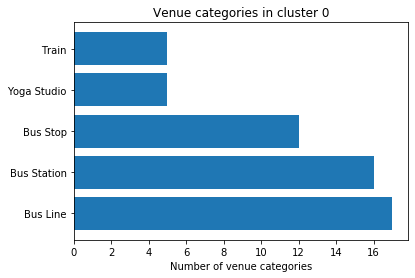

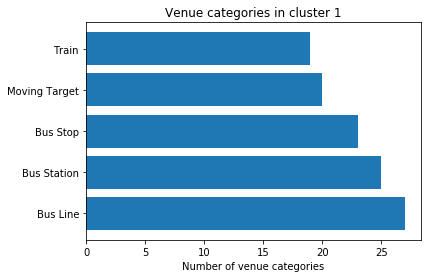

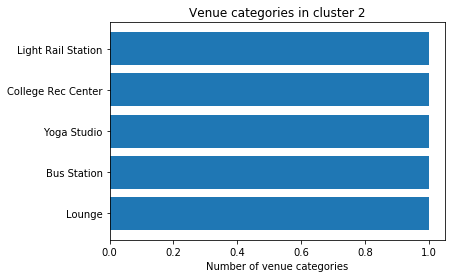

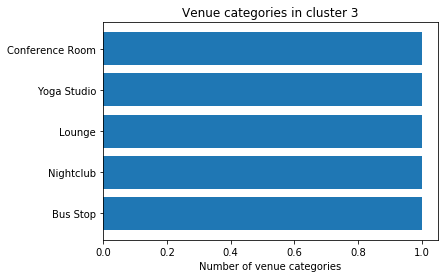

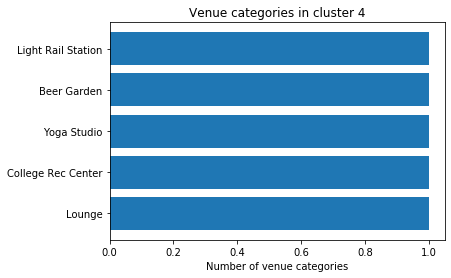

In [721]:
for i in range(kclusters):
    #count venue categories in all neighborhoods in the cluster
    t0 = total_venue_categories(sfo_merged[sfo_merged['Cluster Labels'] == i])
    title = 'Venue categories in cluster ' + str(i)

    y_pos = np.arange(len(t0['Venue Category']))
    plt.barh(y_pos, t0['Venue Count'], align='center')
    plt.yticks(y_pos, t0['Venue Category'])
    plt.xlabel('Number of venue categories')
    plt.title(title)

    plt.show()
    


## Discussion <a class="anchor" id="discuss-sfdata"></a>

In [724]:
cluster_zip = sfo_merged[['zipcode','Cluster Labels']]
cluster_zip.groupby('Cluster Labels').count()

,zipcode
Cluster Labels,
0.0,18
1.0,27
2.0,1
3.0,1
4.0,1


From the above analysis of the zipcodes, it appears that San Francisco is well connected by Buses and Trains. The neighborhoods shown in **Cluster 0 and Cluster 1** are best suited for anyone wanting to use buses and trains to commute within the city.

**Cluster 0** - has about 5 train stations and nearly 45 stations identified as either "Bus Line", "Bus Station" or "Bus Stop". There are **18** zipcodes in this cluster.

**Cluster 1** - has about 20 train stations and nearly 75 stations identified as either "Bus Line", "Bus Station" or "Bus Stop". There are **27** zipcodes in this cluster.

Clearly **Cluster 1** is the best neighborhood in the city of San Francisco to commute by both train and bus, followed by **Cluster 0**